In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import random

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load and prepare data
data = pd.read_csv("/content/drive/MyDrive/combined_data.csv")
ndata = data.dropna().reset_index(drop=True)

text = ndata['text']
labels = ndata['mental_state'].values
label_map = {emotion: idx for idx, emotion in enumerate(np.unique(labels))}
num_labels = len(label_map)
y_encoded = np.array([label_map[l] for l in labels])

In [4]:
embeddings = np.load('/content/drive/MyDrive/roberta_embeddings_yess_2025.npy')


Please ensure you have loaded your data:
- ndata: your cleaned dataframe
- text: text column from ndata
- embeddings: your RoBERTa embeddings
- labels: your mental_state labels
Original class distribution:
anxiety             : 17054 (13.8%)
normal              : 16343 (13.3%)
depression          : 48958 (39.7%)
suicidal            : 25243 (20.5%)
stress              :  2587 (2.1%)
bipolar             :  7765 (6.3%)
personality disorder:  1077 (0.9%)
lonely              :  2820 (2.3%)
ptsd                :  1397 (1.1%)

Training set shape: (98595, 1836)
Training set class distribution:
suicidal            : 20194 (20.5%)
depression          : 39166 (39.7%)
bipolar             :  6212 (6.3%)
normal              : 13074 (13.3%)
anxiety             : 13643 (13.8%)
stress              :  2070 (2.1%)
ptsd                :  1118 (1.1%)
lonely              :  2256 (2.3%)
personality disorder:   862 (0.9%)

Class weights:
anxiety             : 0.8030
bipolar             : 1.7635
depression    

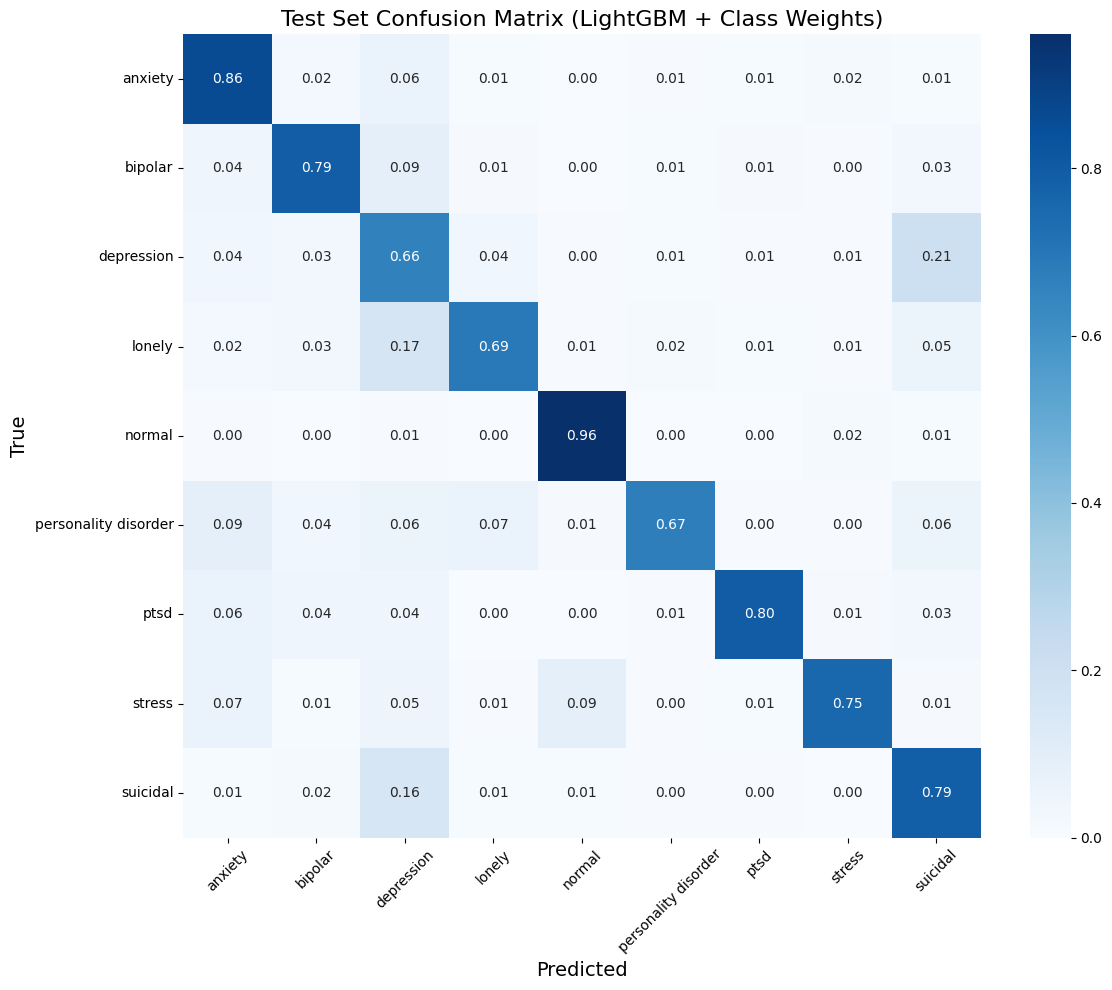


Top 20 Most Important Features:
 1. f605: 68101.5342
 2. f1464: 60770.0168
 3. f369: 60332.1318
 4. f362: 58811.6992
 5. f22: 58288.5524
 6. f374: 57948.6086
 7. f200: 51667.8008
 8. f721: 41198.5282
 9. f651: 24635.4004
10. f501: 7929.1186
11. f52: 4022.5117
12. f377: 3985.3780
13. f1425: 3955.4300
14. f2: 2462.8601
15. f487: 2152.2953
16. f598: 2078.6299
17. f577: 2041.5802
18. f1479: 2025.4900
19. f466: 1923.9766
20. f514: 1681.6500


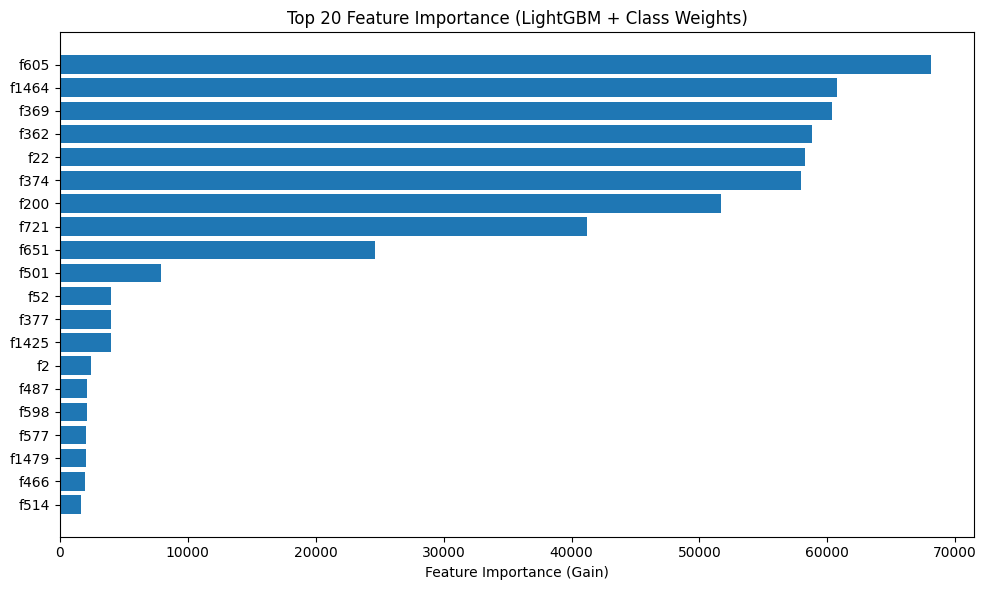


Model saved to /content/drive/MyDrive/models/lightgbm_class_weights_model.txt
Scaler saved to /content/drive/MyDrive/models/lightgbm_scaler.joblib
Label encoder saved to /content/drive/MyDrive/models/lightgbm_label_encoder.joblib
TF-IDF vectorizer saved to /content/drive/MyDrive/models/lightgbm_tfidf.joblib
Class weights saved to /content/drive/MyDrive/models/lightgbm_class_weights.joblib

Prediction function created. Use predict_with_lightgbm() for new predictions.

Alternative: Custom Focal Loss Implementation
You can use the FocalLossLGBM class for iterative focal loss training.
This approach doesn't require custom objective functions and works with any LightGBM version.


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from collections import Counter

# Install required packages (run this first if not installed)
# !pip install lightgbm

import lightgbm as lgb


def create_class_weights(y_train, method='balanced'):
    """
    Create class weights for imbalanced dataset
    """
    class_counts = np.bincount(y_train)
    total_samples = len(y_train)
    n_classes = len(class_counts)

    if method == 'balanced':
        # Standard balanced weights
        class_weights = total_samples / (n_classes * class_counts)
    elif method == 'sqrt':
        # Square root balanced weights (less aggressive)
        class_weights = np.sqrt(total_samples / (n_classes * class_counts))
    else:
        # No weighting
        class_weights = np.ones(n_classes)

    return class_weights


def focal_loss_lgb(y_pred, y_true, alpha=0.25, gamma=2.0):
    """
    Calculate focal loss for multiclass classification
    This is used as a custom evaluation metric
    """
    y_true = y_true.get_label().astype(int)
    num_classes = len(np.unique(y_true))

    # Reshape predictions to (n_samples, n_classes)
    y_pred = y_pred.reshape(num_classes, -1).T

    # Convert to probabilities using softmax
    exp_pred = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
    prob = exp_pred / np.sum(exp_pred, axis=1, keepdims=True)

    # Clip probabilities to avoid log(0)
    prob = np.clip(prob, 1e-15, 1 - 1e-15)

    # Get probabilities for true classes
    true_prob = prob[np.arange(len(y_true)), y_true]

    # Calculate focal loss
    focal_loss = -alpha * (1 - true_prob) ** gamma * np.log(true_prob)

    return 'focal_loss', np.mean(focal_loss), False


# Load your data (assuming you have this part ready)
# For demonstration, I'll create placeholder variables
# Replace these with your actual data loading
# data = pd.read_csv("/content/drive/MyDrive/combined_data.csv")
# ndata = data.dropna().reset_index(drop=True)
# text = ndata['text']
# labels = ndata['mental_state'].values
# embeddings = np.load('/content/drive/MyDrive/roberta_embeddings_yess_2025.npy')

# Uncomment the following lines and replace with your actual data
# For now, I'll use placeholder comments
print("Please ensure you have loaded your data:")
print("- ndata: your cleaned dataframe")
print("- text: text column from ndata")
print("- embeddings: your RoBERTa embeddings")
print("- labels: your mental_state labels")

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(ndata['mental_state'])

print("Original class distribution:")
original_dist = Counter(labels_encoded)
for class_idx, count in original_dist.items():
    print(f"{le.classes_[class_idx]:<20}: {count:5d} ({count/len(labels_encoded)*100:.1f}%)")

# Split the data into train and test sets
X_train_indices, X_test_indices, y_train_final, y_test_final = train_test_split(
    range(len(text)), labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)

# Split text and embeddings
text_train = [text.iloc[i] for i in X_train_indices]
text_test = [text.iloc[i] for i in X_test_indices]
embeddings_train = embeddings[X_train_indices]
embeddings_test = embeddings[X_test_indices]

# Fit TF-IDF ONLY on training data
tfidf = TfidfVectorizer(max_features=300)
tfidf_features_train = tfidf.fit_transform(text_train).toarray()
tfidf_features_test = tfidf.transform(text_test).toarray()

# Combine features for training and test sets
X_train_full = np.hstack([embeddings_train, tfidf_features_train])
X_test_full = np.hstack([embeddings_test, tfidf_features_test])

# Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

print(f"\nTraining set shape: {X_train_scaled.shape}")
print("Training set class distribution:")
train_dist = Counter(y_train_final)
for class_idx, count in train_dist.items():
    print(f"{le.classes_[class_idx]:<20}: {count:5d} ({count/len(y_train_final)*100:.1f}%)")

# Create class weights
class_weights = create_class_weights(y_train_final, method='balanced')
sample_weights = np.array([class_weights[y] for y in y_train_final])

print(f"\nClass weights:")
for i, weight in enumerate(class_weights):
    print(f"{le.classes_[i]:<20}: {weight:.4f}")

# Get number of classes
num_classes = len(np.unique(y_train_final))

# LightGBM parameters optimized for imbalanced classification
lgb_params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'boosting_type': 'gbdt',
    'metric': ['multi_logloss'],
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_weight': 10,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'class_weight': 'balanced',  # Built-in class weighting
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1,
    'force_col_wise': True,
}

# Cross-validation setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_metrics = []

print(f"\n{'='*60}")
print("Starting Cross-Validation with LightGBM + Class Weights...")
print(f"{'='*60}")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train_final)):
    print(f"\n{'='*20} Fold {fold+1} / {n_splits} {'='*20}")

    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train_final[train_idx], y_train_final[val_idx]

    # Create sample weights for this fold
    fold_weights = np.array([class_weights[y] for y in y_fold_train])

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_fold_train, label=y_fold_train, weight=fold_weights)
    val_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data)

    # Train model with custom focal loss evaluation
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ],
        feval=lambda y_pred, y_true: focal_loss_lgb(y_pred, y_true, alpha=0.25, gamma=2.0)
    )

    # Predictions
    y_pred_proba = model.predict(X_fold_val, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Metrics
    accuracy = accuracy_score(y_fold_val, y_pred)
    precision = precision_score(y_fold_val, y_pred, average='weighted')
    recall = recall_score(y_fold_val, y_pred, average='weighted')
    f1 = f1_score(y_fold_val, y_pred, average='weighted')
    val_loss = log_loss(y_fold_val, y_pred_proba)

    print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Loss: {val_loss:.4f}")

    fold_metrics.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'loss': val_loss
    })

# Print average metrics across folds
print("\n" + "="*60)
print("Cross-Validation Results (LightGBM + Class Weights):")
print("="*60)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'loss']:
    values = [fm[metric] for fm in fold_metrics]
    print(f"{metric.capitalize():<10}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# Train final model on full training set
print("\n" + "="*60)
print("Training Final Model with LightGBM + Class Weights")
print("="*60)

# Create full training dataset
train_data = lgb.Dataset(X_train_scaled, label=y_train_final, weight=sample_weights)
test_data = lgb.Dataset(X_test_scaled, label=y_test_final, reference=train_data)

# Train final model
final_model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ],
    feval=lambda y_pred, y_true: focal_loss_lgb(y_pred, y_true, alpha=0.25, gamma=2.0)
)

# Predictions on test set
y_test_pred_proba = final_model.predict(X_test_scaled, num_iteration=final_model.best_iteration)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Test metrics
test_accuracy = accuracy_score(y_test_final, y_test_pred)
test_precision = precision_score(y_test_final, y_test_pred, average='weighted')
test_recall = recall_score(y_test_final, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_final, y_test_pred, average='weighted')
test_loss = log_loss(y_test_final, y_test_pred_proba)

print("\n" + "="*60)
print("Final Test Set Performance (LightGBM + Class Weights)")
print("="*60)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"Log Loss: {test_loss:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test_final, y_test_pred, target_names=le.classes_, digits=4))

# Per-class F1 scores
print("\nPer-class F1 Scores:")
f1_per_class = f1_score(y_test_final, y_test_pred, average=None)
for i, f1_class in enumerate(f1_per_class):
    print(f"{le.classes_[i]:<20}: {f1_class:.4f}")

# Per-class precision and recall
print("\nPer-class Precision:")
precision_per_class = precision_score(y_test_final, y_test_pred, average=None)
for i, prec_class in enumerate(precision_per_class):
    print(f"{le.classes_[i]:<20}: {prec_class:.4f}")

print("\nPer-class Recall:")
recall_per_class = recall_score(y_test_final, y_test_pred, average=None)
for i, rec_class in enumerate(recall_per_class):
    print(f"{le.classes_[i]:<20}: {rec_class:.4f}")

# Confusion matrix
cm_test = confusion_matrix(y_test_final, y_test_pred, normalize='true')
plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Test Set Confusion Matrix (LightGBM + Class Weights)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_lightgbm.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance analysis
feature_importance = final_model.feature_importance(importance_type='gain')
feature_names = [f'f{i}' for i in range(len(feature_importance))]

# Get top 20 features
top_indices = np.argsort(feature_importance)[::-1][:20]
print("\nTop 20 Most Important Features:")
for i, idx in enumerate(top_indices):
    print(f"{i+1:2d}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(20), feature_importance[top_indices][::-1])
plt.yticks(range(20), [feature_names[i] for i in top_indices[::-1]])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Feature Importance (LightGBM + Class Weights)')
plt.tight_layout()
plt.savefig('feature_importance_lightgbm.png', dpi=300, bbox_inches='tight')
plt.show()

# Save models and preprocessors
save_dir = '/content/drive/MyDrive/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save model
model_file = os.path.join(save_dir, 'lightgbm_class_weights_model.txt')
final_model.save_model(model_file)
print(f"\nModel saved to {model_file}")

# Save preprocessors
scaler_file = os.path.join(save_dir, 'lightgbm_scaler.joblib')
joblib.dump(scaler, scaler_file)
print(f"Scaler saved to {scaler_file}")

encoder_file = os.path.join(save_dir, 'lightgbm_label_encoder.joblib')
joblib.dump(le, encoder_file)
print(f"Label encoder saved to {encoder_file}")

tfidf_file = os.path.join(save_dir, 'lightgbm_tfidf.joblib')
joblib.dump(tfidf, tfidf_file)
print(f"TF-IDF vectorizer saved to {tfidf_file}")

# Save class weights
class_weights_file = os.path.join(save_dir, 'lightgbm_class_weights.joblib')
joblib.dump(class_weights, class_weights_file)
print(f"Class weights saved to {class_weights_file}")

# Function to make predictions with the saved model
def predict_with_lightgbm(model_path, scaler_path, tfidf_path, encoder_path,
                         new_text, new_embeddings):
    """
    Function to make predictions using the saved LightGBM model
    """
    # Load model and preprocessors
    model = lgb.Booster(model_file=model_path)
    scaler = joblib.load(scaler_path)
    tfidf = joblib.load(tfidf_path)
    le = joblib.load(encoder_path)

    # Preprocess new data
    tfidf_features = tfidf.transform(new_text).toarray()
    features = np.hstack([new_embeddings, tfidf_features])
    features_scaled = scaler.transform(features)

    # Make predictions
    probabilities = model.predict(features_scaled)
    predictions = np.argmax(probabilities, axis=1)
    predicted_labels = le.inverse_transform(predictions)

    return predicted_labels, probabilities

print(f"\nPrediction function created. Use predict_with_lightgbm() for new predictions.")

# Alternative: Custom Focal Loss Implementation (if you want to try it)
print("\n" + "="*60)
print("Alternative: Custom Focal Loss Implementation")
print("="*60)

class FocalLossLGBM:
    """
    Alternative implementation using post-processing with focal loss weighting
    """

    def __init__(self, alpha=0.25, gamma=2.0):
        self.alpha = alpha
        self.gamma = gamma

    def apply_focal_weighting(self, y_true, y_pred_proba):
        """
        Apply focal loss weighting to sample weights
        """
        # Get the probability of the true class for each sample
        true_class_probs = y_pred_proba[np.arange(len(y_true)), y_true]

        # Calculate focal weights
        focal_weights = self.alpha * (1 - true_class_probs) ** self.gamma

        return focal_weights

    def train_with_focal_reweighting(self, X_train, y_train, X_val, y_val,
                                   initial_weights, lgb_params, n_iterations=3):
        """
        Train model with iterative focal loss reweighting
        """
        current_weights = initial_weights.copy()

        for iteration in range(n_iterations):
            print(f"\nFocal Loss Iteration {iteration + 1}/{n_iterations}")

            # Create datasets with current weights
            train_data = lgb.Dataset(X_train, label=y_train, weight=current_weights)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

            # Train model
            model = lgb.train(
                lgb_params,
                train_data,
                valid_sets=[train_data, val_data],
                valid_names=['train', 'val'],
                num_boost_round=1000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50),
                    lgb.log_evaluation(period=100)
                ]
            )

            # Get predictions on training set
            y_train_pred_proba = model.predict(X_train, num_iteration=model.best_iteration)

            # Calculate focal weights
            focal_weights = self.apply_focal_weighting(y_train, y_train_pred_proba)

            # Combine with class weights
            current_weights = initial_weights * focal_weights

            # Normalize weights
            current_weights = current_weights / np.mean(current_weights) * len(current_weights)

        return model

# Example usage of focal loss implementation
focal_loss_trainer = FocalLossLGBM(alpha=0.25, gamma=2.0)

print("You can use the FocalLossLGBM class for iterative focal loss training.")
print("This approach doesn't require custom objective functions and works with any LightGBM version.")